In [1]:
import numpy as np
import sys
import xarray as xr
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v4'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [4]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SSHDYN','OBPNOPAB'],\
                                           years_to_load=range(1993,2017)).load() # if desired, add after 'SSH','NEW_VAR',...                                           

# 'PHIBOT','OBP','ETAN','SSH',
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  SSHDYN


In [5]:
# ocean_mask is ceiling of hFacC which is 0 for 100% dry cells and
# 0 > hFacC >= 1 for grid cells that are at least partially wet

# hFacC is the fraction of the thickness (h) of the grid cell which
# is wet.  we'll consider all hFacC > 0 as being a wet grid cell
# and so we use the 'ceiling' function to make all values > 0 equal to 1.

ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [6]:
# Method 1: the array index method, []
#           select land_c at k index 0
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask) # [0,:]

In [7]:
# - no need to multiple RAC by land_c because SSH is nan over land
# - average over all grid points (one value per time)  
# global mean time series 
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
# OBP
OBP_global_mean_mon = (ecco_monthly_ds.OBPNOPAB*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

In [8]:
# remove time mean from mean time series (to see trends better) 
SSHDYN_global_mean_mon_ntm = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim='time') 
OBP_global_mean_mon_ntm = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim='time')

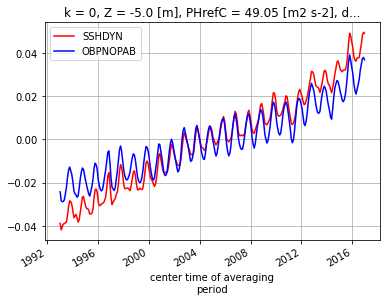

In [9]:
# SSH_global_mean_mon.plot(color='k');
SSHDYN_global_mean_mon_ntm.plot(color='r',label='SSHDYN');
OBP_global_mean_mon_ntm.plot(color='b',label='OBPNOPAB');
plt.legend()
plt.grid()

In [10]:
# Surface Fields 
# MDT_r = (ecco_monthly_ds.SSH - SSH_global_mean_mon)
# MDT = (ecco_monthly_ds.SSH - SSH_global_mean_mon).mean(dim=['time'])           # global average 
# MDT_no_spatial_mean = MDT - MDT*ecco_monthly_ds.rA/total_ocean_area            # subtract from MDT, MDT*cell_area/total_ocean_area 
MDT_r = (ecco_monthly_ds.SSHDYN - SSHDYN_global_mean_mon)
MDT = (ecco_monthly_ds.SSHDYN - SSHDYN_global_mean_mon).mean(dim=['time'])

In [11]:
# Bottom Fields 
OBP = ecco_monthly_ds.OBPNOPAB # [time, tile, lat, lon] 
OBP_r = OBP - OBP_global_mean_mon 

### Subsequent Analysis 
SSH = (SSHDYN - area_weighted_global_mean_time_series) like a sea level anomaly

OBP = (OBPNOPAB - area_weighted_global_mean_time_series) like an anomaly

In [125]:
# CORRELATIONS ACROSS VARIOUS SCALES 
years = np.arange(1993,2017)
corr = xr.corr(OBP_r, MDT_r, dim='time')
# corr_1yr = xr.corr(OBP.loc['1993-01':'1993-'], MDT_r.loc['1993':'1994'], dim='time')
corr_1yr = xr.DataArray(
    data=np.nan * np.ones((len(years), np.shape(OBP)[1], np.shape(OBP)[2], np.shape(OBP)[3])),
    dims=["year","tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], OBP.XC.data), YC=(["tile","j","i"], OBP.YC.data),
        tile=(["tile"], np.arange(13)), year=(["year"], years),
    ),
)
for i in range(len(years)-1):
    corr_1yr[i] = xr.corr(OBP.loc[str(years[i]):str(years[i+1])], \
                          MDT_r.loc[str(years[i]):str(years[i+1])], dim='time').astype('float32')
corr_5yr = xr.corr(OBP.loc['1993':'1997'], MDT_r.loc['1993':'1997'], dim='time')

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


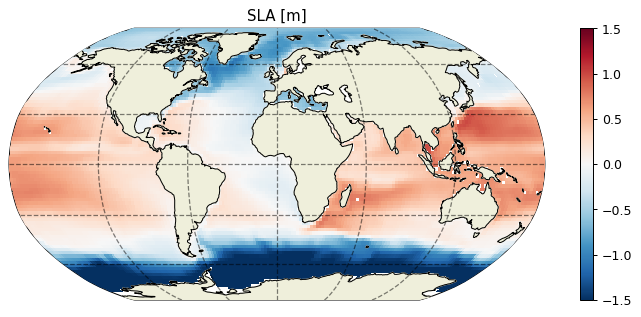

In [12]:
plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              MDT_r[0]*ocean_mask, \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True,cmin=-1.5, cmax=1.5, dx=2,dy=2);
plt.title('SLA [m]');

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


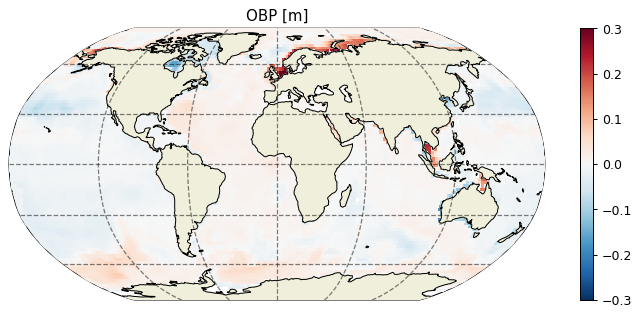

In [17]:
plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              (OBP_r[0]-OBP_r.mean(dim=['time']))*ocean_mask, \
                              user_lon_0=0, plot_type = 'pcolormesh', \
                              show_colorbar=True, dx=2, dy=2, cmin=-0.3, cmax=0.3);
plt.title('OBP [m]');

In [99]:
days_since_first_record = ((ecco_monthly_ds.time - ecco_monthly_ds.time[0])/(86400e9)).astype(int).values
split_i = round(len(days_since_first_record)/2)
# -- 1st half of time series 
obp_flat = np.reshape(OBP_r[0:split_i].values, (len(OBP.time[0:split_i]), 13*90*90))
obp_flat[np.nonzero(np.isnan(obp_flat))] = 0
# slope is in m / day
obp_slope, obp_intercept = np.polyfit(days_since_first_record[0:split_i], obp_flat, 1)
# and reshape the slope result back to 13x90x90    
obp_slope1 = np.reshape(obp_slope, (13,90,90))
# -- second half of time series 
obp_flat = np.reshape(OBP_r[split_i:].values, (len(OBP.time[split_i:]), 13*90*90))
obp_flat[np.nonzero(np.isnan(obp_flat))] = 0
obp_slope, obp_intercept = np.polyfit(days_since_first_record[split_i:], obp_flat, 1)
obp_slope2 = np.reshape(obp_slope, (13,90,90))

# -- 1st half of time series 
ssh_flat = np.reshape(MDT_r[0:split_i].values, (len(MDT_r.time[0:split_i]), 13*90*90))
ssh_flat[np.nonzero(np.isnan(ssh_flat))] = 0
ssh_slope, ssh_intercept = np.polyfit(days_since_first_record[0:split_i], ssh_flat, 1)
ssh_slope1 = np.reshape(ssh_slope, (13,90,90))
# -- second half of time series 
ssh_flat = np.reshape(MDT_r[split_i:].values, (len(MDT_r.time[split_i:]), 13*90*90))
ssh_flat[np.nonzero(np.isnan(ssh_flat))] = 0
ssh_slope, ssh_intercept = np.polyfit(days_since_first_record[split_i:], ssh_flat, 1)
ssh_slope2 = np.reshape(ssh_slope, (13,90,90))

# mask 
# obp_slope_masked = np.where(ocean_mask[0,:] > 0, obp_slope, np.nan)
# convert from m / day to mm/year
# obp_slope_mm_year = obp_slope_masked*365*1e3

In [101]:
obp_trend1 = xr.DataArray(
    data=obp_slope1,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)),j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], OBP.XC.data), YC=(["tile","j","i"], OBP.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
obp_trend2 = xr.DataArray(
    data=obp_slope2,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], OBP.XC.data), YC=(["tile","j","i"], OBP.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
ssh_trend1 = xr.DataArray(
    data=ssh_slope1,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], OBP.XC.data), YC=(["tile","j","i"], OBP.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
ssh_trend2 = xr.DataArray(
    data=ssh_slope2,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], OBP.XC.data), YC=(["tile","j","i"], OBP.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)

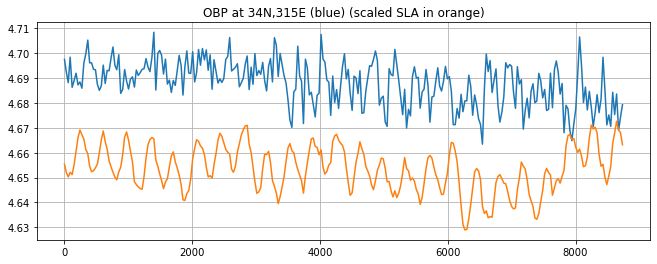

In [136]:
testloc = np.where((OBP.YC > 33) & (OBP.YC < 35) & (OBP.XC > -45) & (OBP.XC < -43))
f, ax = plt.subplots(1,1,figsize=(11,4))
ax.plot(days_since_first_record, OBP_r[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.plot(days_since_first_record, 0.2*MDT_r[:,testloc[0][0],testloc[1][0],testloc[2][0]] + 4.66)
# ax.plot(days_since_first_record[0:split_i], )
ax.set_title('OBP at 34N,315E (blue) (scaled SLA in orange)') 
ax.grid()

0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0


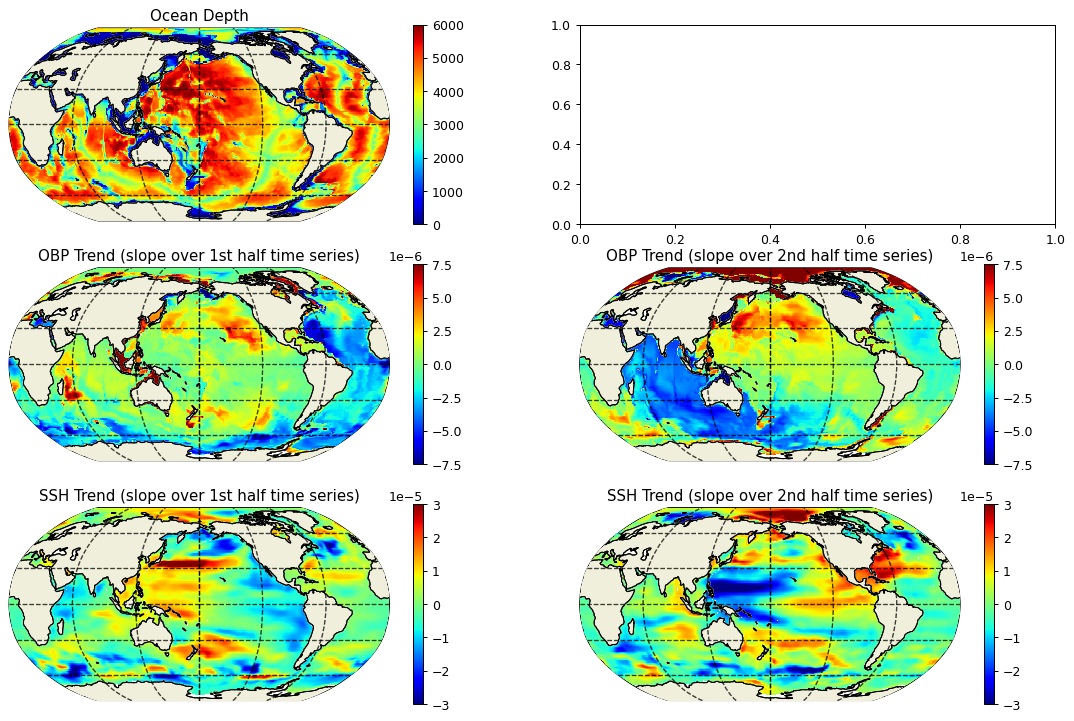

In [113]:
# plt.figure(figsize=(10,4), dpi= 90)
f, ax = plt.subplots(3,2,figsize=(15,10), dpi= 90)
f=plt.subplot(321);
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              ecco_monthly_ds.Depth, \
                              user_lon_0=180, plot_type = 'pcolormesh', cmap='jet', \
                              show_colorbar=True, cmin=0, cmax=6000, dx=1,dy=1, subplot_grid=[3,2,1]);
plt.title('Ocean Depth');
f=plt.subplot(323); # plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              obp_trend1*ocean_mask, \
                              user_lon_0=180, plot_type = 'pcolormesh', cmap='jet', \
                              show_colorbar=True, cmin=-0.75*1e-5, cmax=0.75*1e-5, dx=1,dy=1, subplot_grid=[3,2,3]);
plt.title('OBP Trend (slope over 1st half time series)');
f=plt.subplot(324); # plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              obp_trend2*ocean_mask, \
                              user_lon_0=180, plot_type = 'pcolormesh', cmap='jet', \
                              show_colorbar=True, cmin=-0.75*1e-5, cmax=0.75*1e-5, dx=1,dy=1, subplot_grid=[3,2,4]);
plt.title('OBP Trend (slope over 2nd half time series)');
f=plt.subplot(325); # plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              ssh_trend1*ocean_mask, \
                              user_lon_0=180, plot_type = 'pcolormesh', cmap='jet', \
                              show_colorbar=True, cmin=-3*1e-5, cmax=3*1e-5, dx=1,dy=1, subplot_grid=[3,2,5]);
plt.title('SSH Trend (slope over 1st half time series)');
f=plt.subplot(326); # plt.figure(figsize=(10,4), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              ssh_trend2*ocean_mask, \
                              user_lon_0=180, plot_type = 'pcolormesh', cmap='jet', \
                              show_colorbar=True, cmin=-3*1e-5, cmax=3*1e-5, dx=1,dy=1, subplot_grid=[3,2,6]);
plt.title('SSH Trend (slope over 2nd half time series)');

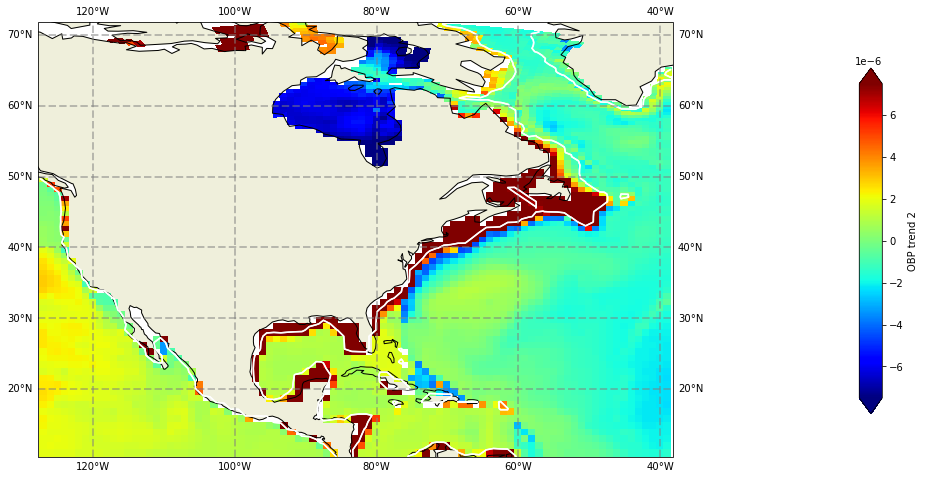

In [175]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
tile_num=10
# pull out lats and lons
lons = np.copy(ecco_monthly_ds.XC.sel(tile=tile_num))
lats = ecco_monthly_ds.YC.isel(tile=tile_num)
tile_to_plot = obp_trend2.isel(tile=tile_num)
Dep_tile_to_plot = ecco_monthly_ds.Depth.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
f, ax = plt.subplots(1,1,figsize=(16,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
oo = ax.pcolor(lons, lats, tile_to_plot, vmin=-0.75*1e-5, vmax=0.75*1e-5, transform=ccrs.PlateCarree(), cmap='jet')
ax.contour(lons, lats, Dep_tile_to_plot, levels=[350, 351], colors='w')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines();ax.add_feature(cfeature.LAND);
cax = f.add_axes([0.95, 0.2, 0.02, 0.6])
f.colorbar(oo, cax=cax, orientation='vertical', extend='both', label='OBP trend 2')

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


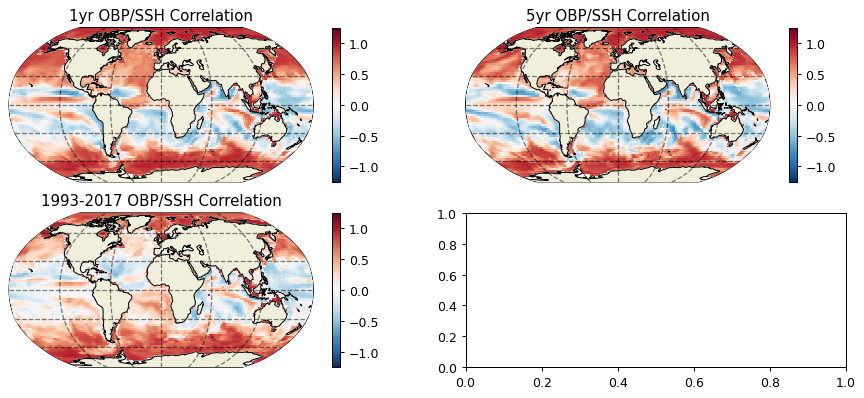

In [68]:
# SSH / OBP Correlation 
clev = [-1.25,1.25]
f, ax = plt.subplots(2,2,figsize=(12,5), dpi= 90)
f=plt.subplot(221);
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              corr_1yr.mean(dim='year')*ocean_mask, user_lon_0=0, plot_type = 'pcolormesh', \
                              show_colorbar=True, cmin=clev[0], cmax=clev[1], dx=2,dy=2, subplot_grid=[2,2,1]);
plt.title('1yr OBP/SSH Correlation');
f=plt.subplot(222);
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              corr_5yr*ocean_mask, user_lon_0=0, plot_type = 'pcolormesh', \
                              show_colorbar=True, cmin=clev[0], cmax=clev[1], dx=2,dy=2, subplot_grid=[2,2,2]);
plt.title('5yr OBP/SSH Correlation')
f=plt.subplot(223);
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              corr*ocean_mask, user_lon_0=0, plot_type = 'pcolormesh', \
                              show_colorbar=True, cmin=clev[0], cmax=clev[1], dx=2,dy=2, subplot_grid=[2,2,3]);
plt.title('1993-2017 OBP/SSH Correlation');

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0
-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


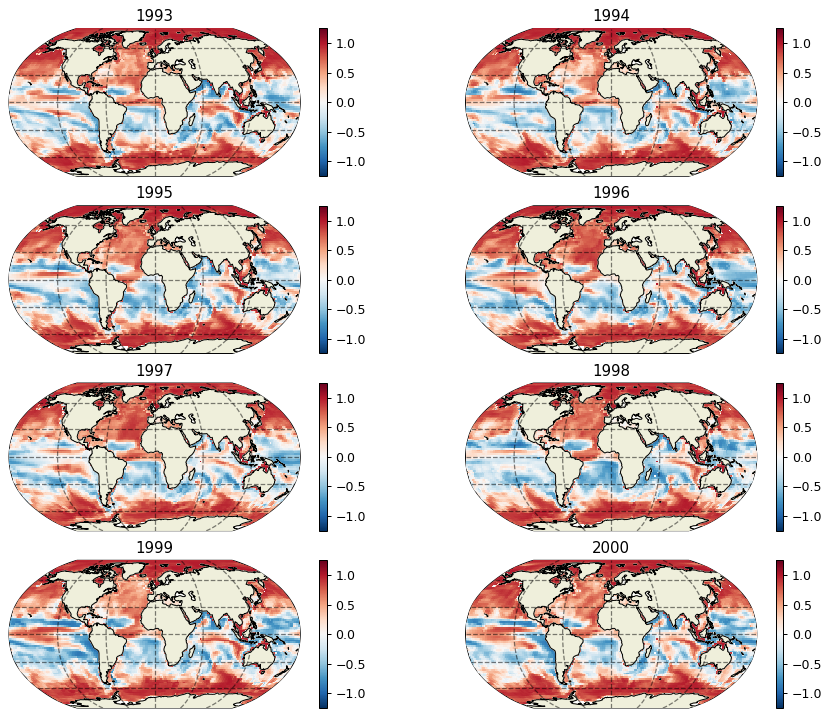

In [69]:
clev = [-1.25,1.25]
f, ax = plt.subplots(4,2,figsize=(12,10), dpi= 90)
gax = ax.flatten()
for i in range(8):
    this_corr = corr_1yr[i]
    this_corr.where(ocean_mask[0,:] !=0)
    ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                                  this_corr*ocean_mask, \
                                  user_lon_0=0, plot_type = 'pcolormesh', \
                                  show_colorbar=True, cmin=clev[0], cmax=clev[1], dx=2,dy=2, subplot_grid=[4,2,i+1]);
    plt.title(str(years[i]))

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


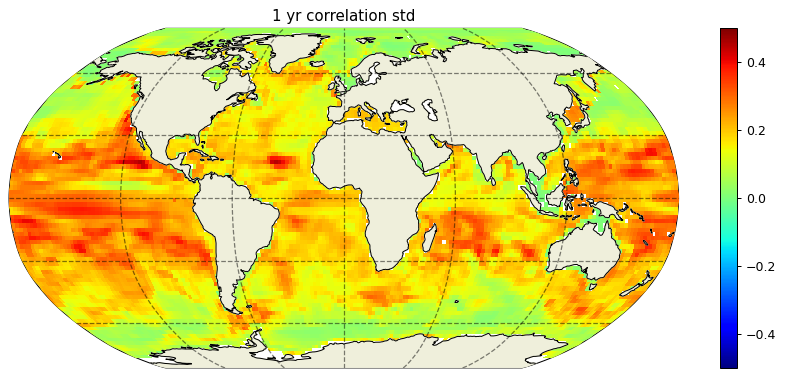

In [70]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, \
                              corr_1yr.std(dim='year')*ocean_mask, \
                              user_lon_0=0, plot_type = 'pcolormesh', \
                              show_colorbar=True, cmap='jet',\
                              cmin=-0.5, cmax=0.5, dx=2,dy=2);
plt.title('1 yr correlation std');